# Алгоритм Гриффина-Лима

**Последовательность выполнения работы:**
- Записать речевой сигнал;
- Построить амплитудную спектрограмму заданного сигнала;
- Воостановить сигнал по спектрограмме.

**Задачи: исследовать зависимость качества преобразования от**
- использования фильтра усиления высоких частот;
- размерность дискретного преобразования Фурье;
- величины сдвига;
- числа итераций алгоритма Гриффина-Лима.

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy

%matplotlib inline

In [2]:
def load_signal(path=''):
    '''Функция загрузки аудиозаписи'''
    signal, sr = librosa.load(path)
    return signal, sr


def pre_emphasis_filters(signal, alpha=.95):
    '''Реализация фильтра для усиления высоких частот'''
    signal_roll = np.roll(signal, shift=1)
    signal_roll[0] = 0
    signal -= alpha * signal_roll
    return signal


def get_spectrogramm(signal, n_fft=2048, hop_length=512):
    '''Функция формирования спектограммы'''
    spec = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    return spec


def show_spec(spec, ax):
    '''Функция визуализации спектрограммы'''
    amplitude = np.abs(spec)
    db = librosa.amplitude_to_db(amplitude)
    librosa.display.specshow(db, y_axis='log', x_axis='time', ax=ax)
    return


def griffin_lim(spec, n_iter=16, n_fft=2048, hop_length=512):
    '''Реализация алгоритма Гриффина-Лима'''
    spec_ = spec.copy()
    for i in range(n_iter):
        X = librosa.istft(spec_, n_fft=n_fft, hop_length=hop_length)
        E = librosa.stft(X, n_fft=n_fft, hop_length=hop_length)
        F = E / np.abs(E)
        spec_  = spec * F
    X = librosa.istft(spec_, n_fft=n_fft, hop_length=hop_length)
    return np.real(X)


def de_emphasis(signal, alpha=.95):
    '''Функция для коррекции сигнала'''
    return scipy.signal.lfilter([1], [1, -alpha], signal)


def vis_signals(signal, sr, src_path='', ax1=None, ax2=None, param=('alpha', .95)):
    '''Функция для визуализации восстановленного и исходного сигнала'''
    librosa.display.waveshow(signal, sr=sr, ax=ax1, x_axis=None)
    ax1.set_title(f'Griffin-Lim result, {param[0]} is {param[1]}')
    wav, sr_ = librosa.load(src_path)
    librosa.display.waveshow(wav, sr=sr_, ax=ax2, x_axis=None)
    ax2.set_title('Source wav')
    return 

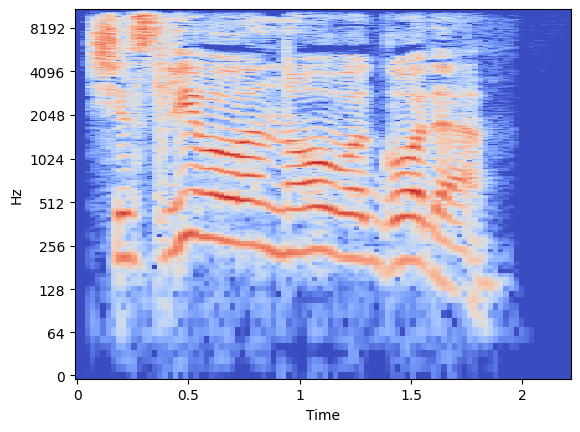

In [3]:
# Загрузим в качестве примера аудио с частотой дискретизации 22КГц и построим спектрограмму
fig, ax = plt.subplots()

signal, sr = load_signal(path='resources/jenskiy-golos.wav')
signal = pre_emphasis_filters(signal, alpha=.95)
spec = get_spectrogramm(signal, 2048, 512)
show_spec(spec, ax)

In [5]:
# Проиграть аудио
ipd.Audio(de_emphasis(griffin_lim(spec)), rate=sr)

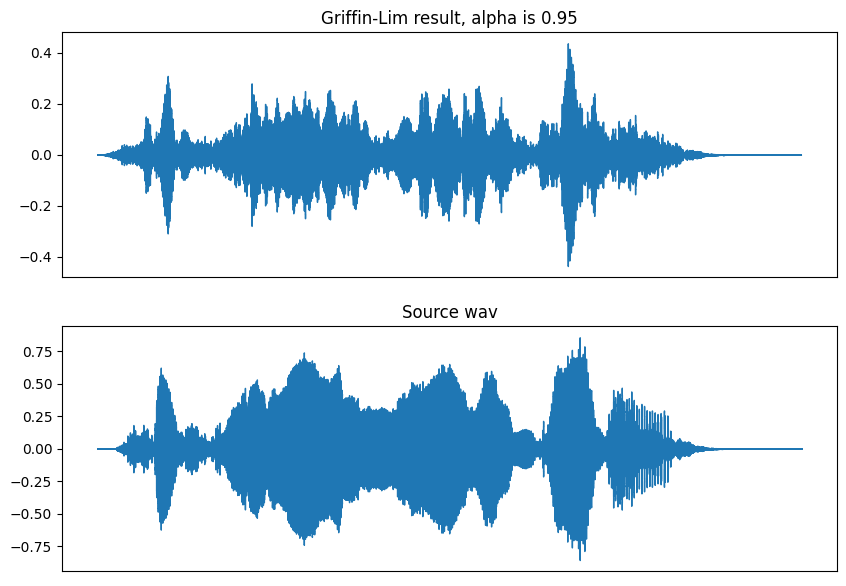

In [6]:
# Отобразить форму сигнала
_, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
vis_signals(de_emphasis(griffin_lim(spec)), sr, 'resources/jenskiy-golos.wav', ax[0], ax[1])

### Рассмотрим зависисмость качества работы алгоритма Гриффина-Лима от параметров фильтра высоких частот

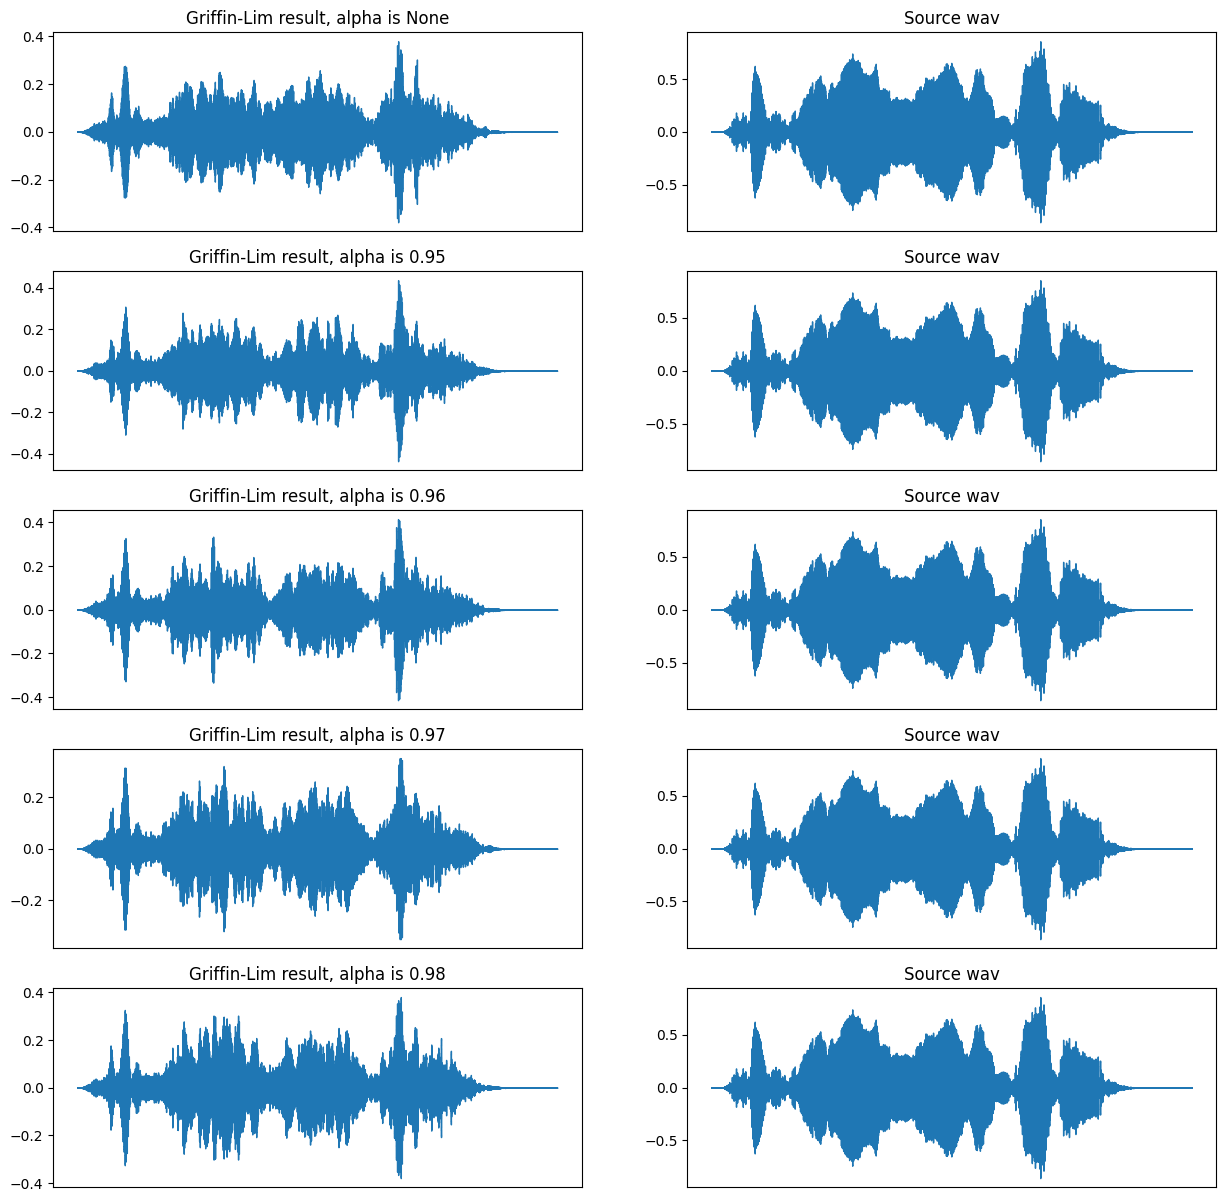

In [7]:
_, ax = plt.subplots(5, 2, figsize=(15, 15), sharex=True)

alpha_values = [None, .95, .96, .97, .98]
audio_ = []
for i, alpha in enumerate(alpha_values):
    signal, sr = load_signal(path='resources/jenskiy-golos.wav')
    if alpha is not None:
        signal = pre_emphasis_filters(signal, alpha=alpha)
        spec = get_spectrogramm(signal)
        signal_ = griffin_lim(spec)
        signal_ = de_emphasis(signal_, alpha=alpha)
    if alpha is None:
        spec = get_spectrogramm(signal)
        signal_ = griffin_lim(spec)
    ax1, ax2 = ax[i % len(alpha_values), 0], ax[i % len(alpha_values), 1]
    vis_signals(signal_, sr, 'resources/jenskiy-golos.wav', ax1, ax2, ('alpha', alpha))
    audio_.append(signal_)

In [8]:
for audio, alpha in zip(audio_, alpha_values):
    print(f'alpha is {alpha}')
    ipd.display(ipd.Audio(audio, rate=sr))

alpha is None


alpha is 0.95


alpha is 0.96


alpha is 0.97


alpha is 0.98


In [9]:
del audio_

`Особых различий между восстановленными сигналами на уровне слухового восприятия выявлено не было. Однако визуальная оценка формы восстановленного сигнала показывает, что наиболее близким является сигнал с параметром alpha = 0.98`

### Рассмотрим зависисмость качества работы алгоритма Гриффина-Лима от размерности дискретного преобразования Фурье

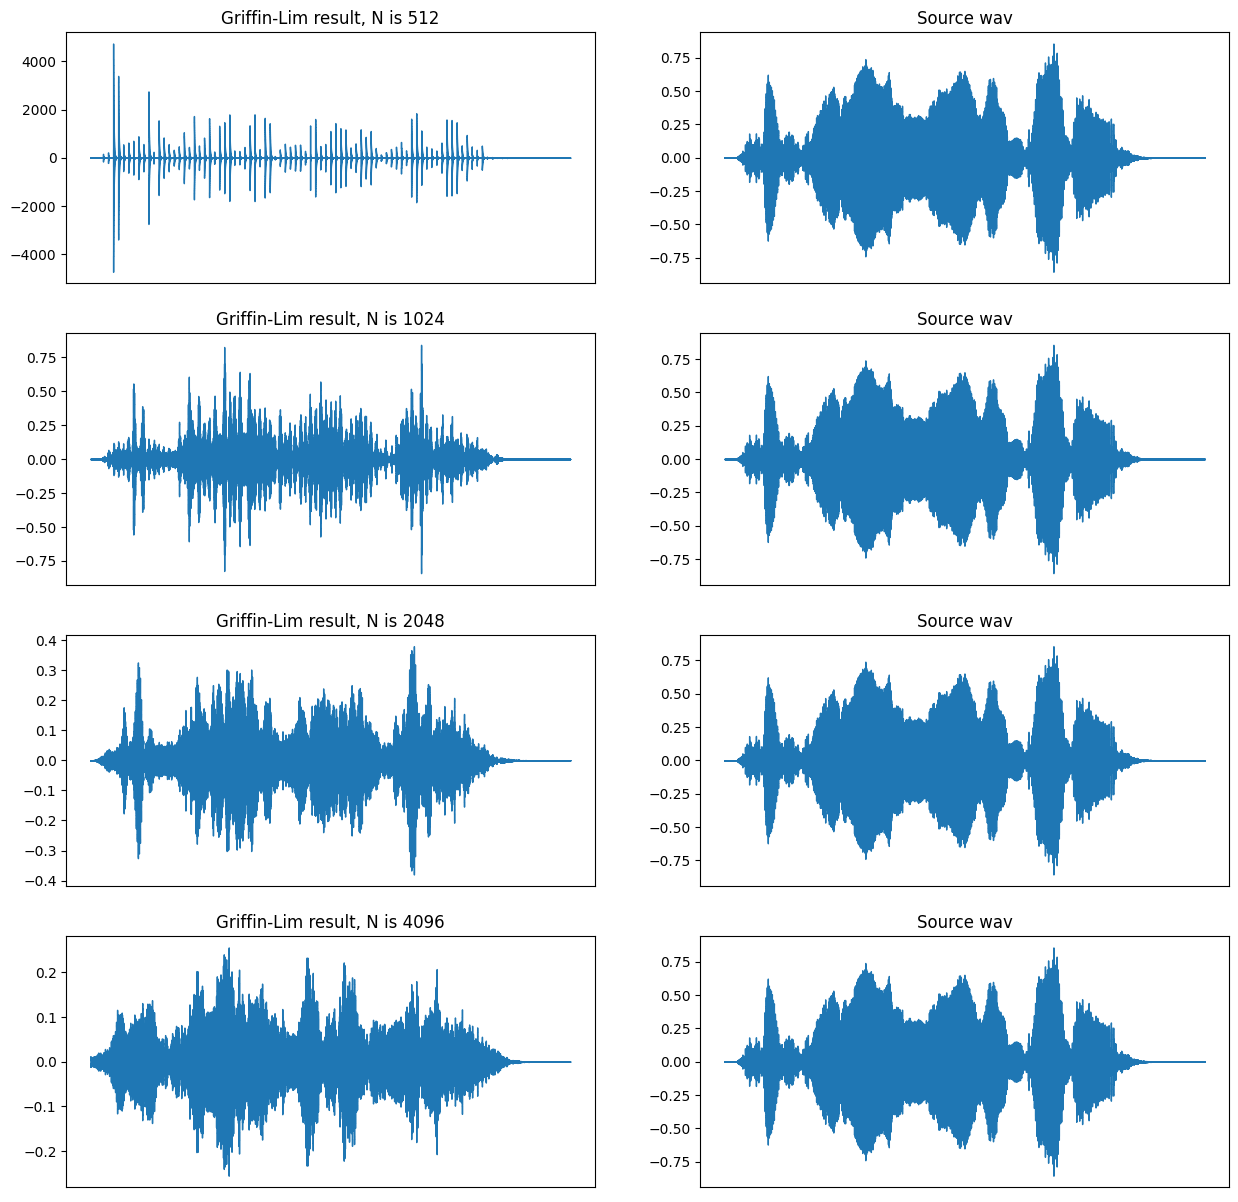

In [10]:
_, ax = plt.subplots(4, 2, figsize=(15, 15), sharex=True)

alpha = .98
n_values = [512, 1024, 2048, 4096]
audio_ = []
for i, n in enumerate(n_values):
    signal, sr = load_signal(path='resources/jenskiy-golos.wav')
    signal = pre_emphasis_filters(signal, alpha=alpha)
    spec = get_spectrogramm(signal, n_fft=n)
    signal_ = griffin_lim(spec, n_fft=n)
    signal_ = de_emphasis(signal_, alpha=alpha)
    ax1, ax2 = ax[i % len(n_values), 0], ax[i % len(n_values), 1]
    vis_signals(signal_, sr, 'resources/jenskiy-golos.wav', ax1, ax2, ('N', n))
    audio_.append(signal_)

In [11]:
for audio, n in zip(audio_, n_values):
    print(f'N is {n}')
    ipd.display(ipd.Audio(audio, rate=sr))

N is 512


N is 1024


N is 2048


N is 4096


In [12]:
del audio_

`По слуховому восприятию, наиболее качественным является сигнал, восстановленный после применения STFT с параметром n_fft=2048. Это также видно по огибающей зуковой волны. Возможно, это связано с тем, что при слишком узком окне в спектрограмме бедное частотное разрешение, а при слишком широком - малая точность по времени`

### Рассмотрим зависисмость качества работы алгоритма Гриффина-Лима от величины сдвига h

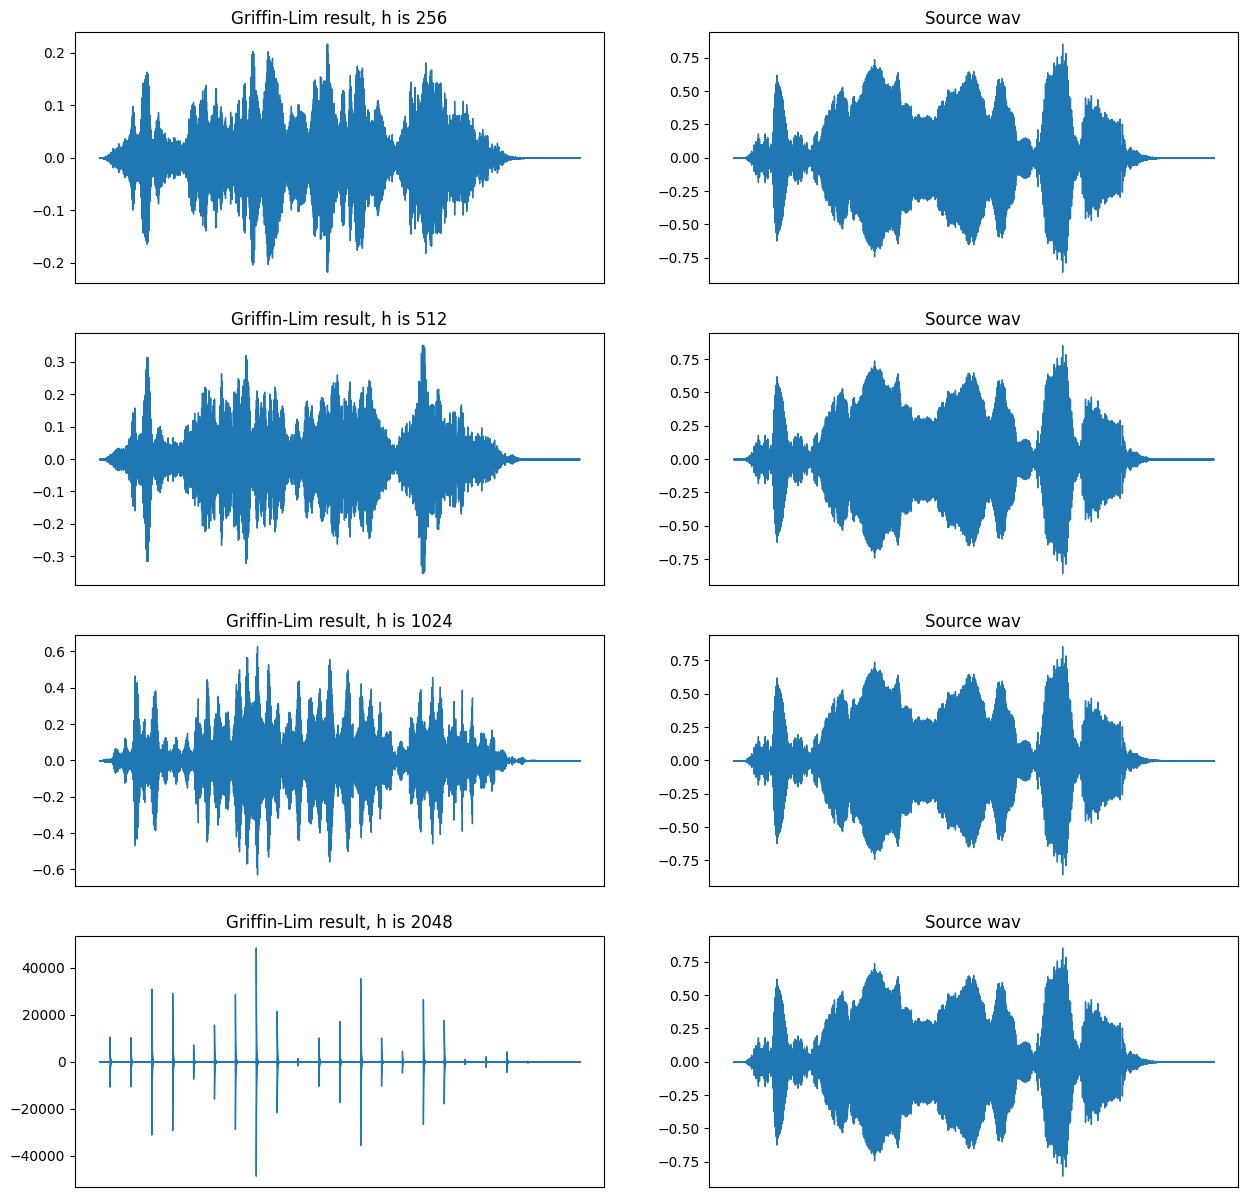

In [26]:
_, ax = plt.subplots(4, 2, figsize=(15, 15))

alpha = .97
n = 2048
h_values = [n // 8, n // 4, n // 2, n]
audio_ = []
for i, h in enumerate(h_values):
    signal, sr = load_signal(path='resources/jenskiy-golos.wav')
    signal = pre_emphasis_filters(signal, alpha=alpha)
    spec = get_spectrogramm(signal, n_fft=n, hop_length=h)
    signal_ = griffin_lim(spec, n_fft=n, hop_length=h)
    signal_ = de_emphasis(signal_, alpha=alpha)
    ax1, ax2 = ax[i % len(n_values), 0], ax[i % len(n_values), 1]
    vis_signals(signal_, sr, 'resources/jenskiy-golos.wav', ax1, ax2, ('h', h))
    audio_.append(signal_)

In [27]:
for audio, h in zip(audio_, h_values):
    print(f'h is {h}')
    ipd.display(ipd.Audio(audio, rate=sr))

h is 256


h is 512


h is 1024


h is 2048


In [28]:
del audio_

`Видно, чем меньше значение сдвига, тем более качественный результат работы алгоритма. Возможно это связано с тем, что при малом сдвиге окна в спектрограмме вероятность "пропуска событий" также мала. Стоит помнить, вычислительная сложность при этом увеличивается`

### Рассмотрим зависисмость качества работы алгоритма Гриффина-Лима от числа итераций

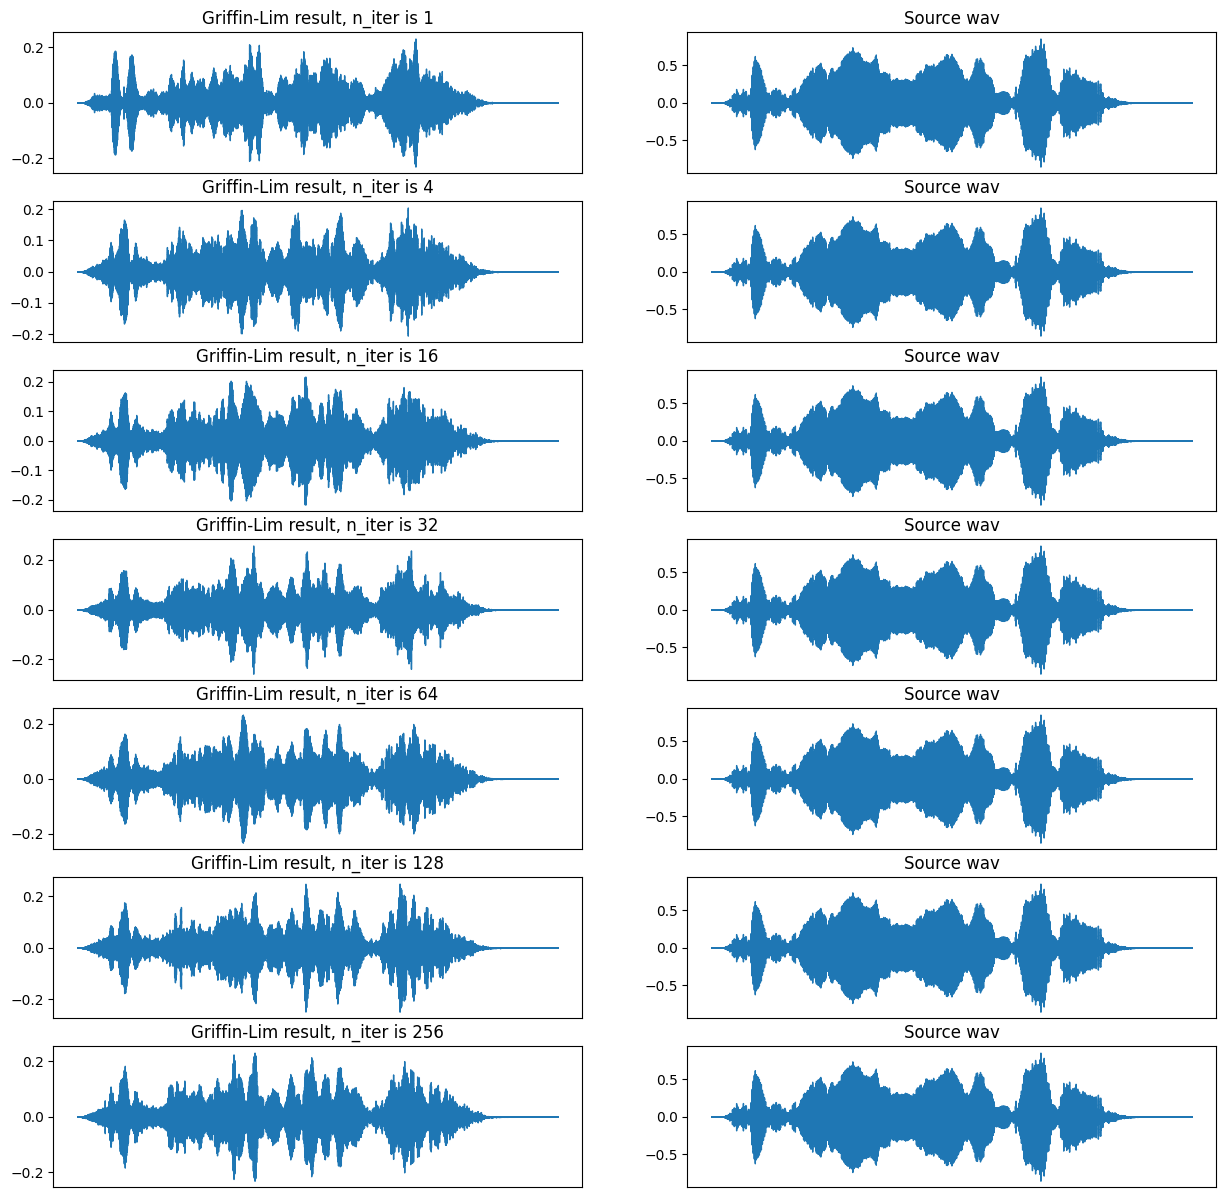

In [36]:
_, ax = plt.subplots(7, 2, figsize=(15, 15))

alpha = .97
n = 2048
h = 256
n_iter_values = [1, 4, 16, 32, 64, 128, 256]
audio_ = []
for i, iter_ in enumerate(n_iter_values):
    signal, sr = load_signal(path='resources/jenskiy-golos.wav')
    signal = pre_emphasis_filters(signal, alpha=alpha)
    spec = get_spectrogramm(signal, n_fft=n, hop_length=h)
    signal_ = griffin_lim(spec, n_fft=n, hop_length=h, n_iter=iter_)
    signal_ = de_emphasis(signal_, alpha=alpha)
    ax1, ax2 = ax[i % len(n_iter_values), 0], ax[i % len(n_iter_values), 1]
    vis_signals(signal_, sr, 'resources/jenskiy-golos.wav', ax1, ax2, ('n_iter', iter_))
    audio_.append(signal_)

In [37]:
for audio, iter_ in zip(audio_, n_iter_values):
    print(f'n_iter is {iter_}')
    ipd.display(ipd.Audio(audio, rate=sr))

n_iter is 1


n_iter is 4


n_iter is 16


n_iter is 32


n_iter is 64


n_iter is 128


n_iter is 256


In [38]:
del audio_

`Видно, что алгоритм Гриффина-Лима дает приемлимые результаты уже в начале первых нескольких итераций. Начиная с некоторого момента, увеличивание итараций не дает существенного прироста в качестве, хотя на итерации 256 форма звуковой волны начала выявлять достаточно специфичные паттерны`

Следует отметить, что, 
- значение `alpha` фильтра усиления высоких частот,
- `размерность` дискретного преобразования Фурье,
- величина `сдвига`,
- `число итераций` алгоритма Гриффина-Лима
- т.д. - можно рассматривать как **гиперпараметры** единой системы синтеза речи.
Данные гиперпарамеры следует оптимизировать. Особенно это удобно, если для оценки качества алгоритма используются не субъективные сравнения, а функции качества. Тогда, можно использовать поиск по `сетке`, подход `RandomSerach`, `байесовскую оптимизацию`.